In [42]:
import twitter 
import json 
import matplotlib
import networkx
import numpy 
import pickle
import sys
import datetime
import time
import matplotlib.pyplot as plt
from sys import maxsize as maxint
from functools import partial
from http.client import BadStatusLine
from urllib.error import URLError

In [43]:
filehandler = open(b"output.txt","wb")

In [44]:
# This function was taken from the Chapter #9 Twitter Cookbook program.
def oauth_login(): 
    CONSUMER_KEY = '2cCNTRk4iJB15OfFXdxegyqD3' 
    CONSUMER_SECRET = 'j0m3jat5YZwLI98fGLlT7r8gOUUqX0pr6pspoCFrjHJyKychhd' 
    OAUTH_TOKEN = '3304948091-uG9cwIktGtohVhchFj54V4D4CVujYA4zPi6Rskq' 
    OAUTH_TOKEN_SECRET = 'BfvBYbMWoaDMgUXxggsme9tJWW0eg8PEQWeqjPH2bNJeo'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET) 
    twitter_api = twitter.Twitter(auth=auth) 
    return twitter_api

In [45]:
# This function was taken from the Chapter #9 Twitter Cookbook program.
def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600:  # Seconds
            printOut('Too many retries. Quitting.', file=sys.stderr)
            raise e

        # See https://developer.twitter.com/en/docs/basics/response-codes
        # for common codes

        if e.e.code == 401:
            printOut('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None
        elif e.e.code == 404:
            printOut('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            printOut('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                printOut("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60 * 15 + 5)
                printOut('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e  # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            printOut('Encountered {0} Error. Retrying in {1} seconds'.format(e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            printOut("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                printOut("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            printOut("BadStatusLine encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                printOut("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [46]:
#This function was taken from the Chapter #9 Twitter Cookbook program.
def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxint, followers_limit=maxint):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
        "Must have screen_name or user_id, but not both"

    # See http://bit.ly/2GcjKJP and http://bit.ly/2rFz90N for details
    # on API parameters

    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                              count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=5000)

    friends_ids, followers_ids = [], []

    for twitter_api_func, limit, ids, label in [
        [get_friends_ids, friends_limit, friends_ids, "friends"],
        [get_followers_ids, followers_limit, followers_ids, "followers"]
    ]:

        if limit == 0: continue
        limit = 5000
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else:  # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']

            printOut('Fetched {0} total {1} ids for {2}'.format(len(ids),
                                                             label, (user_id or screen_name)), file=sys.stderr)

            # XXX: You may want to store data during each iteration to provide an
            # an additional layer of protection from exceptional circumstances

            if len(ids) >= limit or response is None:
                break

    return friends_ids[:friends_limit], followers_ids[:followers_limit]

In [47]:
# The function below is implemented through a methodology that functions to compute the following results:
# Obtain the user_id & the user screen_name through utilization of Twitter API.
# Return the user_id along with the title of the user account. 
def get_screenNum(screenName):
    try:
        screenName = int(screenName)
        user = make_twitter_request(twitter_api.users.lookup, user_id=screenName)
    except:
        name = screenName.replace(" ", "")
        user = make_twitter_request(twitter_api.users.lookup, screen_name=name)
    user = user[0]
    screen_id = (user["id"], user["name"])
    return screen_id

In [48]:
# This function appends all children onto the final program output of the social network graph. 
def append_5(parent, children, graph):
    for i in children:
        graph.add_node((i[0],i[1]))
        graph.add_edge((parent[0], parent[1]), (i[0],i[1]))

In [49]:
# For this function of the program we navigate to the index of the top 5 friends of each layer.
# This computation is executed through computing the maximum followers per friend within the friends list. 
def top_five_indices(list):
    indexes= []
    
    # Helper function to compute maximum number of followers per user in list. 
    def topIndexNavi(numFollowers, acc, num):
        if num > 0 and len(numFollowers)!=0:
            try:
                maxim = numFollowers[0]
                maxim_index = 0
                for i in range(len(numFollowers)):
                    if (numFollowers[i] > maxim):
                        maxim = numFollowers[i]
                        maxim_index = i
                acc.append(maxim_index)
                numFollowers[maxim_index] = 0
                # Recursive loop for the computation of maximum followers per user.
                topIndexNavi(numFollowers, acc, num-1)
            except:
                # Returned in case of user not containing friends within the user's personalized Twitter account.
                print("Error: Account does not contain followers for", acc)
    # End of helper function --> return to parent function of "top_five_indices".
    topIndexNavi(list, indexes, 5)
    printOut(indexes) 
    return indexes

In [50]:
# This function was taken from the Chapter #9 Twitter Cookbook program.
def setwise_friends_followers_analysis(screen_name, friends_ids, followers_ids):
    friends_ids, followers_ids = set(friends_ids), set(followers_ids)
    printOut('{0} is following {1}'.format(screen_name, len(friends_ids)))
    printOut('{0} is being followed by {1}'.format(screen_name, len(followers_ids)))
    printOut('{0} of {1} are not following {2} back'.format(
        len(friends_ids.difference(followers_ids)),
        len(friends_ids), screen_name))
    printOut('{0} of {1} are not being followed back by {2}'.format(
        len(followers_ids.difference(friends_ids)),
        len(followers_ids), screen_name))
    printOut('{0} has {1} mutual friends'.format(
        screen_name, len(friends_ids.intersection(followers_ids))))

In [51]:
# The function implemented in this cell functions precisely as follows:
# Function obtains reciprocal friends of the parent user screen_name. 
# Depth of reciprocal friends calculation for the parent user is pre-defined. 
def get_reciprocal_friends(twitter_api, parent, depth, graph):
    if depth > 0:
        printOut("Number of nodes within the graph:", graph.number_of_nodes()) 
        printOut("Current parent node:") 
        printOut(parent) 
        
        # Compute top five reciprocal friends of the parent and append to list with parent node user_id.
        top_recip = nav_top_five_users(twitter_api, parent[0])
        
        printOut("The top five reciprocal friends are as follows:") 
        printOut(top_recip) 
        
        # Append top five reciprocal friends to the final outputted social network graph of the parent user.
        append_5(parent, top_recip, graph)
        for i in top_recip:
            # Recursive loop to obtain top five reciprocal friends per graph node layer.
            get_reciprocal_friends(twitter_api, i, depth-1, graph)

In [52]:
# Self-implemented Twitter friends/followers Crawler function for the specified user.

# The function implemented below operates and computes precisely as the Twitter Cookbook crawler function: 
# Get the friends and followers of the parent user node.
# Compute the list of reciprocal users between friends and followers of parent user through list conversion and intersection implementation.
# Convert set to list and concatenate both lists.
# Compute top five indices and the top five friends through function calls to previously implemented function calls. 

def nav_top_five_users(twitter_api, user_id):
    top_friends = []
    followers_list = []
    tuples_list = []
    
    try:
        friends_ids, followers_ids = get_friends_followers_ids(twitter_api, user_id=user_id,
                                                       friends_limit=maxint,
                                                       followers_limit=maxint)
        friends_ids = set(friends_ids)
        followers_ids = set(followers_ids)
        #printOut("Friends:", friends_ids) 
        #printOut("Followers:", followers_ids) 
        
        reciprocal_users = followers_ids & friends_ids
        reciprocal_users = list(reciprocal_users)
        reciprocal_users = ','.join([str(item) for item in reciprocal_users[:100]])
        
        comb_reciprocals = make_twitter_request(twitter_api.users.lookup, user_id=reciprocal_users)
        
        for i in comb_reciprocals:
            num_followers = i["followers_count"]
            protected_users = i["protected"]
            id = i["id"]
            name = i["screen_name"]
            combined_total = (id, name, num_followers, protected_users)
            tuples_list.append((combined_total))
            
        # List comprehension for elimination of private accounts.
        non_priv_users = [x for x in tuples_list if x[3] == False]
        print(non_priv_users)
        for i in non_priv_users:
            # Append num_followers of specific users into single list with private accounts deleted.
            followers_list.append(i[2])
            
        # Call helper function top_five_indices for index assignment.
        five_ind = top_five_indices(followers_list)
        try:
            for j in five_ind:
                top_friends.append((non_priv_users[j][0], non_priv_users[j][1]))
        except:
            printOut("Unexpected Error:", sys.exc_info())
        printOut("Here are the top five reciprocal friends of the parent user node:") 
        printOut(top_friends) 
        return top_friends
    except:
       printOut("Unexpected outer layer error:", sys.exc_info()[0]) 
       return top_friends


In [53]:
# Funcion implemented below produces the social network graph with appendage of reciprocal users onto the graph.
def make_graph(twitter_api, user_ID, depth):
    graph = networkx.Graph()
    seed = get_screenNum(user_ID)
    graph.add_node((seed[0], seed[1]))
    get_reciprocal_friends(twitter_api, seed, depth, graph)
    return graph

In [54]:
# Specific function for program output to both console and a file through implementation of pickle package.
def printOut(*args, **kwargs):
    pickle.dump("\n", filehandler)
    pickle.dump(" ".join(map(str, args)), filehandler)
    print(" ".join(map(str, args)))

Number of nodes within the graph: 1
Current parent node:
(755103970754953216, 'Connor Toomey')
Fetched 246 total friends ids for 755103970754953216
Fetched 138 total followers ids for 755103970754953216
[(1615541073127825408, 'ElsingaRyan', 1, False), (1600608241683251200, 'quinn_urich', 9, False), (1197702009404755968, 'JoeyPalatsky', 287, False), (1002805054674354177, 'chuck_stevie', 121, False), (1332199118526005249, 'BricenNygaard', 11, False), (1274583042422603779, 'BillyStoddard4', 9, False), (1046070430774243334, 'brianjrudman', 276, False), (997552376671363078, 'niko_benelli', 55, False), (1240804654990180358, 'AndrewB41693693', 8, False), (804662042640715776, 'gavinjeffers2', 310, False), (1131949477231775745, 'FoleyHagen', 61, False), (3318093827, 'Tthayer_8102', 287, False), (1170477705546129411, 'Calchristo1', 413, False), (2726688807, 'ekxlls', 531, False), (2460341804, 'Liv44123', 154, False), (3434872378, 'kayleeclairmont', 377, False), (2745542721, 'cmodes16', 349, Fals

Fetched 5000 total friends ids for 2890027590
Fetched 5000 total followers ids for 2890027590
[(1304127561321021440, 'nahtarabp', 129, False), (794376452607279104, 'Jalen_P48', 658, False), (2299002882, 'Habfan60', 587, False), (1342682464112705536, '_gonefishing__', 48, False), (1327608797070721024, 'CanucksNostalg1', 110, False), (1253509912044371973, 'AliJXie', 533, False), (1349435876368023552, 'schwifty00', 62, False), (1338471282015305728, 'ShowerShoeLord', 3149, False), (1597993923858661384, 'xLakeShowBabyx', 602, False), (1299346436547510272, 'LetItFl50612690', 63, False), (1360408416519290881, 'RealMikeVersace', 868, False), (1257574055701512194, 'JustinC94019825', 14368, False), (1613961347531669516, 'mlbmarr', 35, False), (1631004127730827277, 'sodapopmm', 11, False), (1579541439763054605, 'TaraBeaner', 84, False), (1233616468132036616, 'KatieCattMouse', 199, False), (1274869293121929223, 'RoyalsJayhawks', 1941, False), (1358253455136161800, 'mattystkachuk', 388, False), (13

Fetched 1476 total friends ids for 1482728463236751367
Fetched 3133 total followers ids for 1482728463236751367
[(1246113656934465536, 'james_sackville', 317, False), (718977765584814081, 'Cole_Hayden1099', 154, False), (1616964165779734529, 'CommittedBaseb1', 65, False), (793983702158213123, 'NickVagnoneKU', 5139, False), (1320166980729569283, 'AaronWa72891350', 24, False), (1247954043076476933, 'medley_nolan', 245, False), (899780484179296260, 'dennis_vilela', 504, False), (1013124518917890049, 'jtdonald15', 310, False), (1364991594286481416, 'CoachBandin', 680, False), (1424490912286187523, 'nate_hayworth', 88, False), (1360617225649070084, 'CoachMMatthews', 227, False), (1422704768837984267, 'calewalters23', 167, False), (710150622650245125, 'geoff_kimmel', 2095, False), (1351600816818429958, 'Hit_Dingers', 92, False), (1374054277333671947, 'HawleyCoach', 117, False), (1286801158405840908, 'coach_drew24', 857, False), (1397291451898339344, 'CadeSpencer11', 123, False), (168722440, 

Fetched 1094 total friends ids for 2479112800
Fetched 1364 total followers ids for 2479112800
[(1038278728336531457, '13_atorres', 147, False), (1094744425224388608, 'MaxElli19579683', 191, False), (708406534049538049, 'j_huckans', 204, False), (1084680046428778496, 'EmilySpinner1', 17, False), (1065397108612710400, 'Jessepstein1', 32, False), (1025415586929672199, 'jazlynj26', 121, False), (982715305775550470, 'millnnial', 307, False), (781971985865773056, 'georgehoang814', 92, False), (968925593143267338, 'kenzzrose07', 196, False), (626982923, 'dantescuzz', 715, False), (2458933261, 'kenzhouck', 211, False), (803733510, 'JoButt16', 1390, False), (2368894982, 'burkie5000', 103, False), (1358092298, '_bellaaquino', 238, False), (829054161060823044, 'GPiskutz', 51, False), (3054817301, 'Proulx_Jordan', 349, False), (4827539479, 'kasualkique', 66, False), (1514414101, 'cgr1120', 440, False), (2396850201, '19hotag', 445, False), (511002649, 'quentinpjl', 681, False), (1321009176, 'campit

Fetched 863 total followers ids for 1087236176
[(1420492939256606720, 'Gibran_Crook', 442, False), (701886962236579840, 'SafetKastrat', 3106, False), (755916840241549312, 'sam_defusco', 104, False), (1129372458862227459, 'AdrienLamora', 165, False), (1445785133697560577, 'saniya_powell', 28, False), (1041835126953586689, 'MACandMAIN', 183, False), (1161010326684557312, 'paige_girardi', 124, False), (782027766267015169, 'jess_casey5', 154, False), (1365765739043581959, 'ChloeChaffin2', 38, False), (1382395835317649417, 'QUWBB_Recruit', 891, False), (1244024210806263811, 'BKranbuhl', 127, False), (1112948205350780933, 'JohnFratianni', 146, False), (876491756333916169, 'JillianHuerter', 456, False), (64868360, 'CoachYoungNJ', 3325, False), (3819696143, 'emmaguthier', 130, False), (3428165639, 'a_vanroy', 292, False), (786966169018171396, 'MadisonDunlap2', 142, False), (4115390487, 'grantlaustrup3', 389, False), (3085297689, 'jbrez30', 98, False), (879895718793707525, 'morgan_obrien11', 52

Fetched 643 total friends ids for 2369869582
Fetched 777 total followers ids for 2369869582
[(912133039672741888, 'jaqucliff', 72, False), (1173776015220338689, 'evan_beland', 38, False), (1389597661381148674, 'liamhassett6', 27, False), (997573351110561793, 'seanmlller', 43, False), (874384754157789185, 'TravisFry22', 142, False), (1251141734148591621, 'ajlawton32', 106, False), (752909484708728832, 'paulh7242', 326, False), (1345537685935558656, 'LukeWag51159640', 19, False), (829406779465400328, 'Sec2hockey', 769, False), (834532579332255752, 'iamdrewphillips', 101, False), (1358092298, '_bellaaquino', 238, False), (626982923, 'dantescuzz', 715, False), (1084632765063184387, 'riggi_adam', 12, False), (4646166541, 'mikewesttt', 59, False), (784459615488573441, 'gustavinhrigats', 118, False), (830225476979458049, 'TylerBowen111', 112, False), (3054817301, 'Proulx_Jordan', 349, False), (191643670, 'joeburke23', 569, False), (2681880605, 'speck_sean', 240, False), (2726688807, 'ekxlls',

Fetched 754 total friends ids for 240437495
Fetched 3048 total followers ids for 240437495
[(909489711550468096, 'ajo_baller', 873, False), (1605045764371136513, '518CDHOOPZ', 69, False), (1406250475557638146, 'emmacrahan', 41, False), (930120504924672002, 'Griffin__Haas', 1281, False), (1223435371335290880, 'CDYRugby', 100, False), (1613620047469023237, '2BaseballMedia', 63, False), (1590090803963215874, 'TedRemsnyder', 60, False), (1399761930479362055, 'dutchmen_lax', 220, False), (1410284302877790214, 'cantguardlouie', 78, False), (1441084952028745736, 'SUNYADK_mbb', 662, False), (1454170619126353921, 'vvillegirlshoop', 55, False), (1500647680330108930, 'VellonJhai', 71, False), (1360605926370197516, 'CoachLambert600', 148, False), (1555241737886568452, 'BlueDevils_CHS1', 337, False), (241256462, 'PHolehan', 266, False), (1453150927960018950, 'UpstateWaite', 505, False), (1427346858108723208, 'NiskyAthletics', 606, False), (1427636071186173969, 'GreenjacketsFB', 66, False), (1665288

Fetched 1076 total friends ids for 1165019520
Fetched 2370 total followers ids for 1165019520
[(770835464790085632, 'chriswitda_', 30, False), (1493294650081304577, 'ProHooperD1', 1489, False), (776615914557018112, 'goat_squad_swag', 179, False), (1341366771710894083, 'james_dontarius', 25, False), (1081735142434111491, 'CoachCrarey', 24126, False), (1110280561996779525, 'frieeeeed', 22, False), (929812569069584388, 'kxlla_edits', 25345, False), (1246271365151428615, 'yaboyjake20', 11, False), (803733510, 'JoButt16', 1390, False), (703964382427025408, 'CardarelliAmber', 325, False), (770393511589974021, 'Tmere3', 205, False), (807743887209091076, '_cdotwavy', 46, False), (2320842765, 'briiittbratt', 1401, False), (711334843766980613, 'redd_raliek', 597, False), (444207121, 'chrisdmartin_', 955, False), (2433773586, 'CapCourtVision', 172, False), (587722771, 'Airyjudge', 829, False), (473522197, 'andrew_canavos', 6744, False), (191643670, 'joeburke23', 569, False), (336873495, 'Coach_Da

Fetched 5000 total friends ids for 817661098988019712
Fetched 5000 total followers ids for 817661098988019712
[(1555397672265195520, 'thatguymitchy', 1545, False), (1241961515130880001, 'Com3andTakeIt', 833, False), (1206348482531020802, 'Dreamer592', 85, False), (1524837278215860224, 'oldwick1e', 39, False), (1020417851470073857, 'Catmom51', 1025, False), (1251527913696043009, 'WeThePe24556202', 2, False), (1281080620119142400, 'In2thelight2', 6, False), (137942186, 'tedhayesjr', 1510, False), (18833999, 'MadetrMom', 36, False)]
[0, 7, 4, 1, 2]
Here are the top five reciprocal friends of the parent user node:
[(1555397672265195520, 'thatguymitchy'), (137942186, 'tedhayesjr'), (1020417851470073857, 'Catmom51'), (1241961515130880001, 'Com3andTakeIt'), (1206348482531020802, 'Dreamer592')]
The top five reciprocal friends are as follows:
[(1555397672265195520, 'thatguymitchy'), (137942186, 'tedhayesjr'), (1020417851470073857, 'Catmom51'), (1241961515130880001, 'Com3andTakeIt'), (1206348482

Fetched 5000 total friends ids for 16534038
Fetched 5000 total followers ids for 16534038
[(827565072113340416, 'CourtneyRitch14', 17, False), (781263617769472001, 'circleoptics', 143, False), (1326418611699847169, 'Emma_Stilllookn', 420, False), (1543560053503950851, 'DIWoodward57', 47, False), (1367506576337207300, 'restore_relax', 9, False), (1366486389911617541, 'MelissaGoddeau', 66, False), (1388900706128629765, 'CunningMiles', 77, False), (1317919237357404167, 'GhostOfSusanBA1', 145, False), (1163990504897417216, 'venetos17', 2957, False), (1266927314748739585, 'Travis78711855', 3, False), (1530171310504087553, 'AliTaylorBuks', 15, False), (1336370276930621447, 'LisaClemens14', 2, False), (16091657, 'warm1013', 422, False), (1382508305646489608, 'ChrissyPing', 4, False), (1420803619620888588, 'wxchanneldesk', 1643, False), (1275564338997268487, 'chuck_hinkel', 70, False), (1445411923063934984, 'sara_annphotog', 14, False), (1466823685088686088, 'CNN_Sara', 257, False), (248834715

Fetched 671 total friends ids for 2421140381
Fetched 686 total followers ids for 2421140381
[(1164003485039452161, 'unamaliii', 21, False), (1336477661036761090, 'thatbishyesh', 61, False), (1160554406481465344, 'giannacgia', 78, False), (1254911512852008965, 'MadisonElia', 61, False), (1153685960883933184, 'hayley_bonavita', 22, False), (984185630124138496, 'CR_Redemption', 338, False), (1112948205350780933, 'JohnFratianni', 146, False), (1136077289412845578, 'ciaraajadeee', 142, False), (1110177246554271749, 'Ronnoc1419', 58, False), (3428165639, 'a_vanroy', 292, False), (705576679800897537, 'juliaeak', 358, False), (3438229521, 'TheLatinFire', 5251, False), (511002649, 'quentinpjl', 681, False), (2396850201, '19hotag', 445, False), (1552068644, 'MaeveeeCahilll', 338, False), (1689198642, 'devinhunt05', 461, False), (2707185715, 'ryandowlingg', 405, False), (3460614201, 'katrinalange06', 108, False), (584532042, 'geowill13', 180, False), (1087236176, 'catttalmeida', 863, False), (477

Fetched 879 total friends ids for 1609594992
Fetched 1553 total followers ids for 1609594992
[(1281445841211981824, 'sanskiie', 195, False), (1576524605862428672, 'ItsAhzaria', 811, False), (1330359211746848770, 'ChaChaBoyyy', 94, False), (1273084871116816384, 'itsjaiisharee', 166, False), (1578942727538053121, 'mayahjayy', 75, False), (1329442985340243971, 'wertz_zanaria', 53, False), (1285412452612616194, 'Daraliz19', 24, False), (1066471243757559808, 'TyierraG', 3026, False), (1554992538657996801, 'Keetolifee', 19, False), (1551630772968345603, 'TheOnly_LalaV', 52, False), (1356979286670991362, 'Ducebigalow10', 22, False), (1485386659206205443, 'Fendyyx', 17, False), (1394307139007569924, 'l0nelychild_', 22, False), (1424187725100503046, 'LatifQueenasia', 47, False), (1243170813282594829, 'matchdeejaay', 135, False), (839944756578947081, 'NadiMonroe', 248, False), (1365357946419478531, 'CurryKayu', 31, False), (3438229521, 'TheLatinFire', 5251, False), (763408970572763136, 'Dodgitoo

Fetched 772 total friends ids for 279695479
Fetched 884 total followers ids for 279695479
[(1599639253482446848, 'KhonsuJasmine', 2, False), (1520787700177154049, '5DTarie', 117, False), (1525635106014208002, 'dripofparadise', 118, False), (1574043276956647425, 'ThutiDjhuteHab', 260, False), (1470520572090142724, 'ninjasniperpon', 22659, False), (772959945591558144, 'egz31', 74, False), (1384693973877334017, 'jayydenm_', 3, False), (1501392827321884675, 'AwakeInDreams', 9015, False), (1136077289412845578, 'ciaraajadeee', 142, False), (1428918258216878085, 'Jackson11eon', 13, False), (772682545205051396, 'pegglesss', 177, False), (1327359147881459723, 'LanaJove', 22097, False), (913412112, 'andrew_ward11', 307, False), (191643670, 'joeburke23', 569, False), (1109336094, 'Ethan_Evans2', 1028, False), (395034665, 'CH1G', 581, False), (2267807786, 'dapperdistress', 42900, False), (342284332, 'traysmalls2227', 793, False), (2800797744, '718_kev', 72, False), (1689198642, 'devinhunt05', 461,

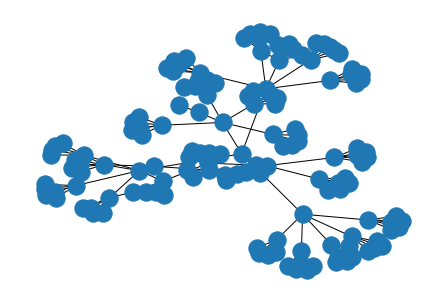

In [55]:
# Main Method implementation.
if __name__ == '__main__':
    twitter_api = oauth_login()
    writer = open("Program_Output.txt", "w+")
    
    # Parent user node.
    screenName = "ConnorToomey_"
    
    # Produce tree of all nodes within the social network with a depth of three layers, thus 125 nodes within our graph.
    graph = make_graph(twitter_api, get_screenNum(screenName)[0],3)
    
    # Draw graph with labels per node.
    networkx.draw(graph, with_labels=False)
    
    # Print graph details.
    printOut("Total # of Nodes:", graph.number_of_nodes()) 
    string = "Total # of Nodes:" + str(graph.number_of_nodes())
    writer.write(string)
    printOut("Total # of Edges:", graph.number_of_edges()) 
    string = "\nTotal # of Edges: "+ str(graph.number_of_edges())
    writer.write(string)
    printOut("Diameter of the tree:", networkx.diameter(graph)) 
    string = "\nDiameter of the tree: "+ str(networkx.diameter(graph))
    writer.write(string)
    string = "\nAverage Distance:"+ str(networkx.average_shortest_path_length(graph))
    writer.write(string)
    printOut("Average Distance:", networkx.average_shortest_path_length(graph)) 


    #save a low-resolution picture of the graph
    plt.savefig("Map.png")

    #show the graph
    plt.show()

    #close file writers
    filehandler.close()
    writer.close()